# load and create variables for plotting

In [10]:
df <- read.table('county_level_df_with_fitted_values',sep=',')

#df$log_corona_underreport <- log10(df$corona_underreport)
df$corona_underreport <- df$corona_underreport*-1

#normalize to per million people
norm <- (df$population/1000000)

df$log_corona_cases <- log10(df$corona_cases/norm)
df$log_corona_deaths <- log10(df$corona_deaths/norm)
df$log_fitted_deaths <- log10(df$fitted_deaths/norm)
df$log_fitted_cases <- log10(df$fitted_deaths*100/norm)

# create and save U.S county maps for: predicted and measured COVID-19 deaths, predicted and measured COVID-19 cases and underreporting

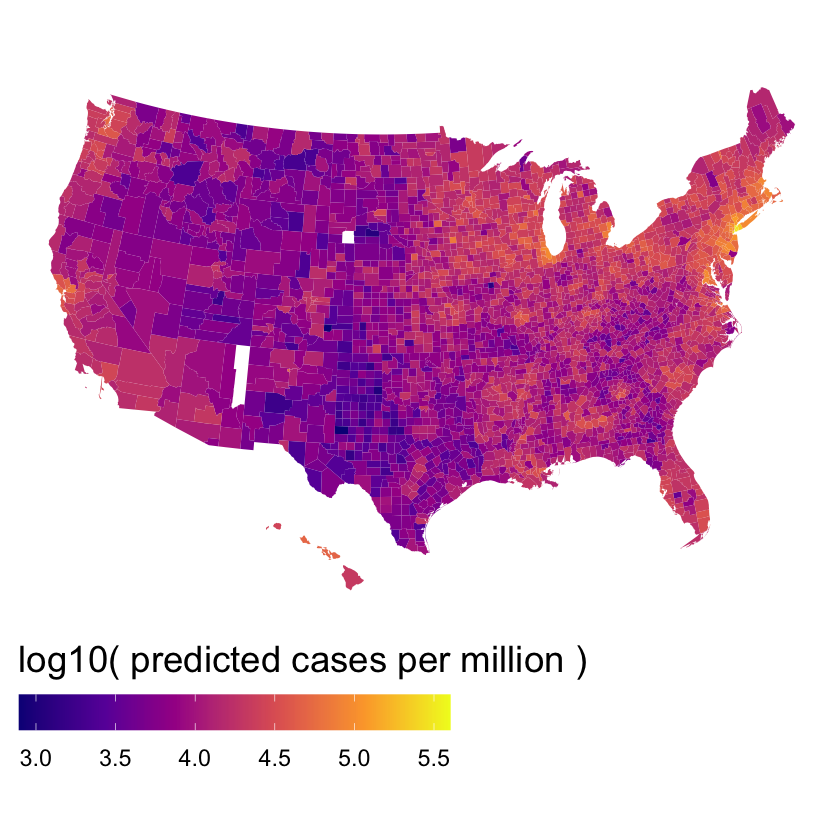

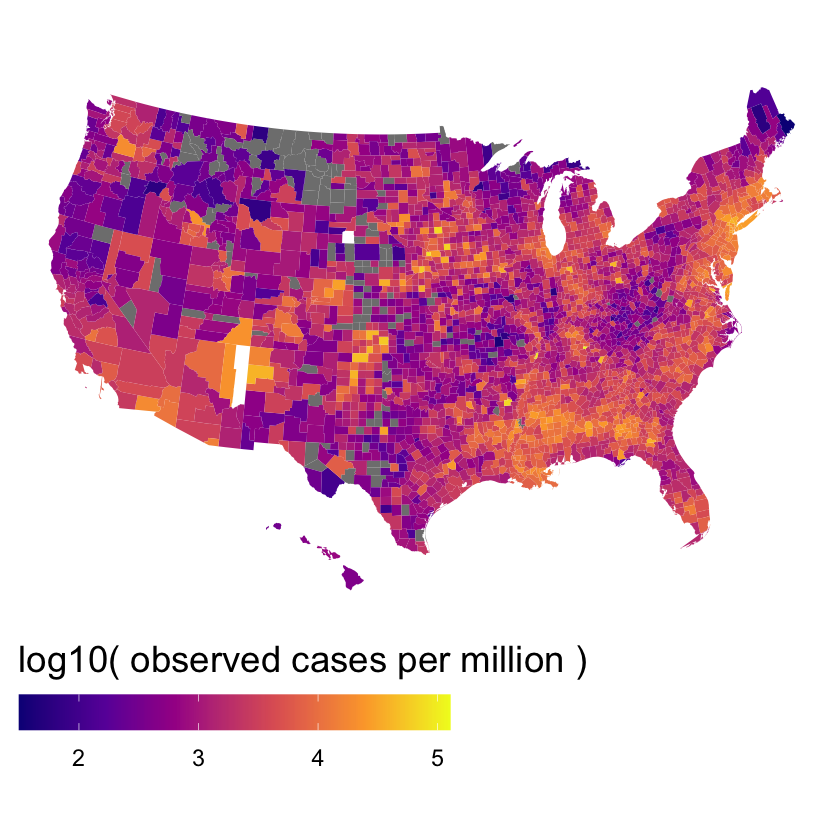

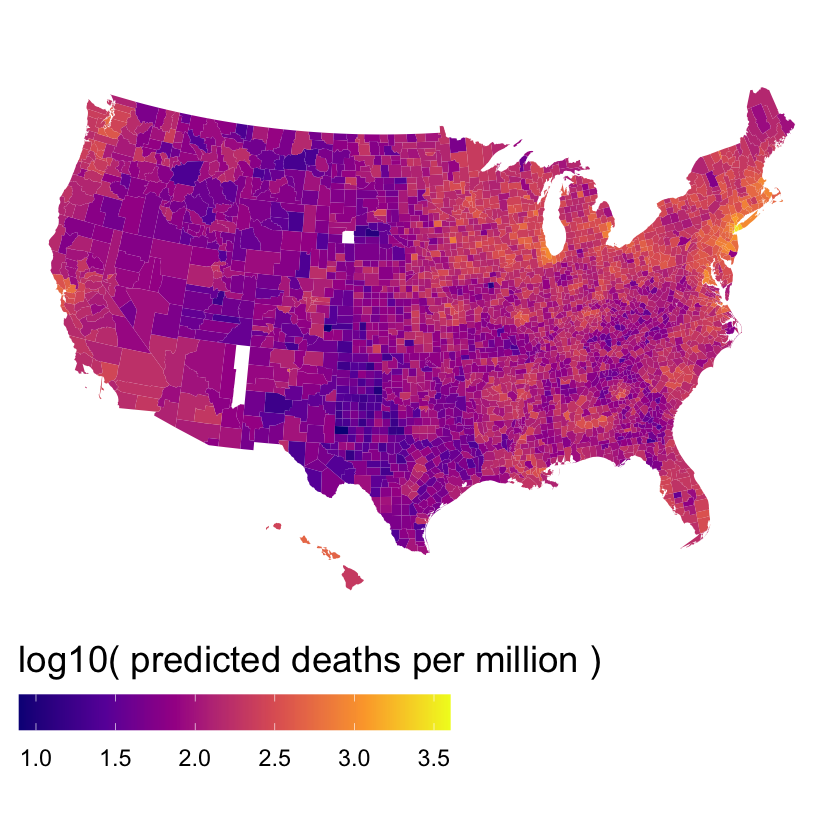

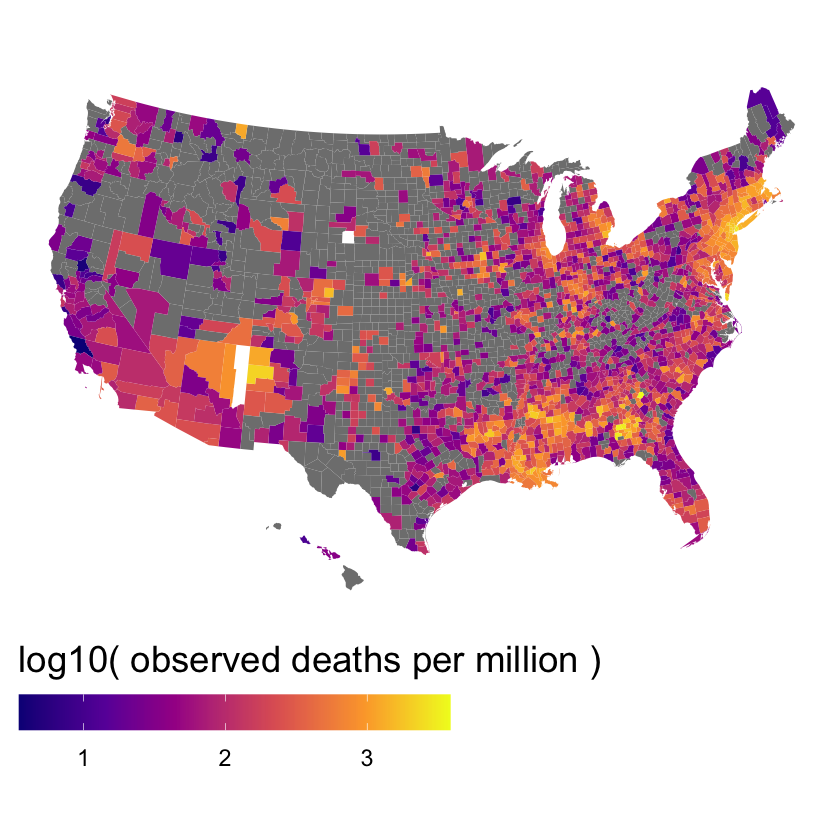

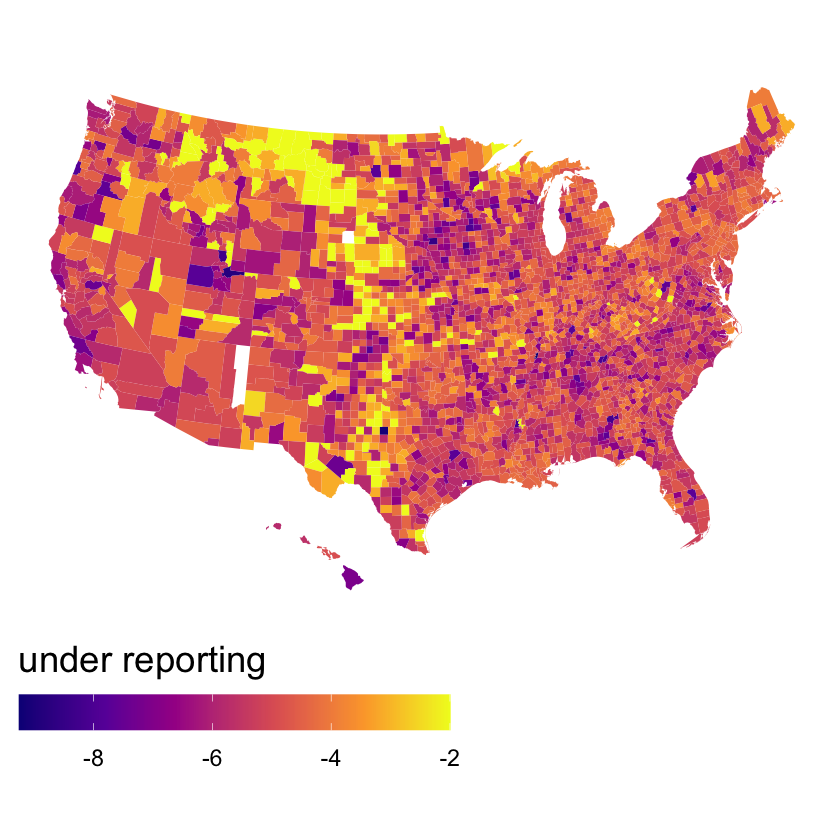

In [11]:
library(maps)
library(socviz)
library(dplyr)
library(ggplot2)
library(ggthemes)

get_df_in_facet_format <- function(col,name) {
    df1 <- df[,c('FIPS',col)]
    colnames(df1) <- c('FIPS','log10_cases')
    df1$type <- name
    return(df1)
}

make_map_plot <- function(){
    df1 <- get_df_in_facet_format(col_name, title) 
    #df_deaths <- get_df_in_facet_format('log_corona_cases', 'observed cases') 
    #log_corona_cases <- get_df_in_facet_format('log_corona_cases') 
    #log_corona_underreport <- get_df_in_facet_format('log_corona_underreport') 

    #df1<-rbind(df_fit_deaths,df_deaths)#,log_corona_cases,log_corona_underreport)

    county_full <- left_join(df1,county_map,  by = "FIPS")

#ggplot(tn, aes(x = long, y = lat, group = group)) + 
#  geom_polygon(aes(fill = group, color = group))    

    p <- ggplot(data = county_full,
                mapping = aes(x = long, y = lat,
                              fill = log10_cases, 
                              group = id)) + geom_polygon(color=NA, size = 0.) + 
                    coord_equal() +
    scale_fill_viridis_c(option = "plasma") + guides(fill = guide_colourbar(barwidth = 18, barheight =1.5,
                                                title= title, title.position = 'top')) 
    
    p + theme_map()  + #facet_wrap(~ type, ncol = 2)  + 
        theme(legend.text=element_text(size=14), legend.position = 'bottom',
              strip.background = element_blank(), strip.text = element_text(size=25),
             legend.title=element_text(size=22)) +
    ggsave(paste('maps/',title,'.pdf',sep=''), width = 8, height = 8)  
}

county_map$FIPS <- as.integer(county_map$id)


title <- 'predicted cases per million'
col_name <- 'log_fitted_cases'
title <- paste('log10(', title, ')')
make_map_plot()

title <- 'observed cases per million'
col_name <- 'log_corona_cases'
title <- paste('log10(', title, ')')
make_map_plot()


title <- 'predicted deaths per million'
col_name <- 'log_fitted_deaths'
title <- paste('log10(', title, ')')
make_map_plot()


title <- 'observed deaths per million'
col_name <- 'log_corona_deaths'
title <- paste('log10(', title, ')')
make_map_plot()


title <- 'under reporting'
col_name <- 'corona_underreport'
make_map_plot()

# percentage increase in deaths from becoming a 75% Republican county to 75% Democrat county

In [7]:
z <- df[c('voteshare_diff', 'log_population','log_ICU_beds', 'prop_uninsured','log_income', 'mean_age', 'obesity','log_density_pop',
          'log_SCI_CN', 'log_SCI_IT','log_SCI_IR')]

R<-apply(z, 2, FUN = mean)
D<-apply(z, 2, FUN = mean)

R['voteshare_diff'] <- -0.75
D['voteshare_diff'] <- 0.75

df_new <- as.data.frame(rbind(R,D))

load(file="model_deaths_nonet.rda")
res<-exp(predict(model_deaths_nonet, newdata = df_new))
print(c('% increase in deaths:',100*(res[2] - res[1])/res[1]))

                                              D 
"% increase in deaths:"      "97.7641696898255" 


# save texreg table with results for Latex

In [22]:
library("tnam")
library('lmtest')
library('rsq')
library('sandwich')
library('prodlim')
library("texreg")


#load fitted regressions
load(file="model_undereport_nonet.rda")
load(file="model_undereport.rda")
load(file="model_deaths_nonet.rda")
load(file="model_deaths.rda")

#get sanwhich heteroskadastic standard errors
model_deaths_SE<-coeftest(model_deaths, vcov = sandwich)
model_deaths_nonet_SE<-coeftest(model_deaths_nonet, vcov = sandwich)
model_undereport_nonet_SE<-coeftest(model_undereport_nonet, vcov = sandwich)

#model_undereport_SE<-coeftest(model_undereport, vcov = sandwich)
model_undereport_SE<-extract(model_undereport)
P <- model_undereport_SE@pvalues
SE <- model_undereport_SE@se
R2 <- model_undereport_SE@gof[1]

# print R^2 values for each equation
c('model_deaths_nonet',rsq(model_deaths_nonet,type='kl',adj=TRUE))
c('model_deaths',rsq(model_deaths,type='kl',adj=TRUE))
c('model_undereport_nonet',rsq(model_undereport_nonet,type='kl',adj=TRUE))
c('model_undereport',model_undereport_SE@gof[1])

#lists of adjusted SE and p values
SE <- list(as.vector(model_deaths_SE[2:14,2]), as.vector(model_undereport_SE@se)*10
          )

P <- list(as.vector(model_deaths_SE[2:14,4]), as.vector(model_undereport_SE@pvalues)
         )

COEF <- list(as.vector(model_deaths_SE[2:14,1]), as.vector(model_undereport_SE@coef)*-10
         )

#custom names of coeffcients
custom.coef.names <- c('$v$', "log($p$)", '$B$' ,"$U$", 'log($In$)', '$a$', '$Ob$','log($\\rho$)', 'log($SCI_{CN}$)', 
'log($SCI_{IT}$)', 'log($SCI_{IR}$)', '$\\kappa_1$' , '$\\kappa_2$')

#save as latex table
texreg(list(model_undereport,model_undereport), single.row = TRUE, file='tnam_regression_results',dcolumn = TRUE, booktabs = TRUE, 
       use.packages = FALSE, label = "table_lnam_regression_results", caption = "Socioeconomic determinents of Coronavirus",
       float.pos = "hb!",custom.model.names = c('corona_deaths','corona_undereporting'),custom.coef.names=custom.coef.names,
      override.se = SE, override.pvalues = P, , override.coef=COEF)

Loading required package: xergm.common

Loading required package: ergm

Loading required package: network

network: Classes for Relational Data
Version 1.16.0 created on 2019-11-30.
copyright (c) 2005, Carter T. Butts, University of California-Irvine
                    Mark S. Handcock, University of California -- Los Angeles
                    David R. Hunter, Penn State University
                    Martina Morris, University of Washington
                    Skye Bender-deMoll, University of Washington
 For citation information, type citation("network").
 Type help("network-package") to get started.



ergm: version 3.10.4, created on 2019-06-10
Copyright (c) 2019, Mark S. Handcock, University of California -- Los Angeles
                    David R. Hunter, Penn State University
                    Carter T. Butts, University of California -- Irvine
                    Steven M. Goodreau, University of Washington
                    Pavel N. Krivitsky, University of Wollongong
 

[1] "model_deaths_nonet" "0.893539446622083"

[1] "model_deaths"      "0.907602974324328"

[1] "model_undereport_nonet" "0.287506816099052"

[1] "model_undereport"  "0.146127767764098"

The table was written to the file 'tnam_regression_results'.




In [21]:
#load fitted regressions
load(file="model_undereport_nonet.rda")
load(file="model_undereport.rda")
load(file="model_deaths_nonet.rda")
load(file="model_deaths.rda")

#get sanwhich heteroskadastic standard errors
model_deaths_SE<-coeftest(model_deaths, vcov = sandwich)
model_deaths_nonet_SE<-coeftest(model_deaths_nonet, vcov = sandwich)
model_deaths_SE<-coeftest(model_deaths, vcov = sandwich)
model_undereport_nonet_SE<-coeftest(model_undereport_nonet, vcov = sandwich)

#model_undereport_SE<-coeftest(model_undereport, vcov = sandwich)
model_undereport_SE<-extract(model_undereport)
P <- model_undereport_SE@pvalues
SE <- model_undereport_SE@se
R2 <- model_undereport_SE@gof[1]

# print R^2 values for each equation
c('model_deaths_nonet',rsq(model_deaths_nonet,type='kl',adj=TRUE))
c('model_deaths',rsq(model_deaths,type='kl',adj=TRUE))
c('model_undereport_nonet',rsq(model_undereport_nonet,type='kl',adj=TRUE))
c('model_undereport',model_undereport_SE@gof[1])

#lists of adjusted SE and p values
SE <- list(as.vector(model_deaths_SE[2:14,2]), as.vector(model_undereport_SE@se)*10
          )

P <- list(as.vector(model_deaths_SE[2:14,4]), as.vector(model_undereport_SE@pvalues)
         )

COEF <- list(as.vector(model_deaths_SE[2:14,1]), as.vector(model_undereport_SE@coef)*-10
         )

#custom names of coeffcients
custom.coef.names <- c('$v$', "log($p$)", '$B$' ,"$U$", 'log($In$)', '$a$', '$Ob$','log($\\rho$)', 'log($SCI_{CN}$)', 
'log($SCI_{IT}$)', 'log($SCI_{IR}$)', '$\\kappa_1$' , '$\\kappa_2$')

#save as latex table
texreg(list(model_undereport,model_undereport), single.row = TRUE, file='tnam_regression_results',dcolumn = TRUE, booktabs = TRUE, 
       use.packages = FALSE, label = "table_lnam_regression_results", caption = "Socioeconomic determinents of Coronavirus",
       float.pos = "hb!",custom.model.names = c('corona_deaths','corona_undereporting'),custom.coef.names=custom.coef.names,
      override.se = SE, override.pvalues = P, , override.coef=COEF)

ERROR: Error in abs(coefs): non-numeric argument to mathematical function
